<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/mlp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we will train an MLP to classify handwritten digits using MNIST dataset. The MNIST dataset is a set of 60,000 training
images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. This is considered as the "Hello World" of deep learning.

The process will be broken down into the following steps:

1. Load and visualize the data
2. Define a neural network
3. Define a Loss function and optimizer
4. Train the model on the training dataset
5. Evaluate the performance of the trained model on the test dataset


## Load and visualize dataset

In [1]:
# import required libraries
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
transform = transforms.ToTensor()

train_x = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_x = datasets.MNIST(root="data", train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
# specify the image classes
classes = ['0','1','2','3','4','5', '6','7','8','9']

In [5]:
# percentage of training set to use as validation
valid_size = 0.2

# split dataset into train and test datasets 
m = len(train_x) # num of training examples
indices = list(range(m))
np.random.shuffle(indices)
split = int(np.floor(valid_size * m))
train_idx, valid_idx = indices[split:], indices[:split]

In [6]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_x, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_x, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=batch_size, num_workers=num_workers)

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

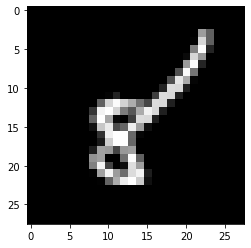

In [8]:
# visualize a training example
img = np.squeeze(images[1])
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

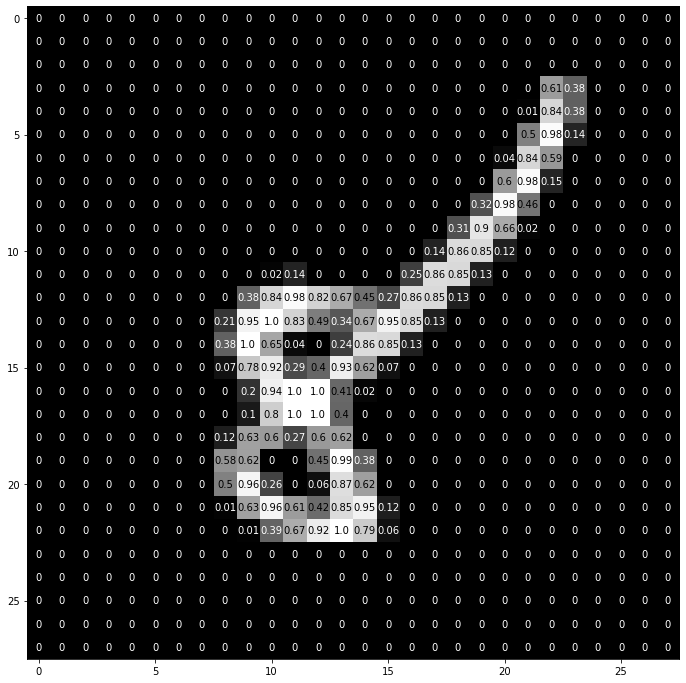

In [9]:
# visualize an example in more detail
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

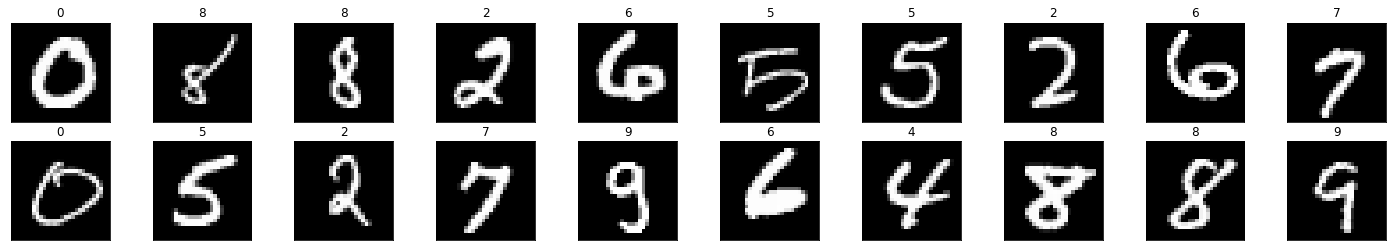

In [10]:
# plot a batch of training images along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[i]), cmap="gray")
  ax.set_title(str(labels[i].item()))

## Define a neural network

In [11]:
# define the neural network architecture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28, 512) 
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 10)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x
  
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [12]:
# display model
summary(model, input_size=(batch_size, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
           Dropout-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
           Dropout-4                  [-1, 512]               0
            Linear-5                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.63
----------------------------------------------------------------


## Define a Loss function and optimizer

In [13]:
# specify loss (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Train the model

In [14]:
# function to calculate accuracy
def calc_acc(loader):
    correct = 0
    total = 0
    for inputs, labels in loader:
    # move tensors to GPU if CUDA is available
      if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
      outputs = model(inputs)
      # # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    return ((100 * correct)/ total)

In [15]:
def training(epochs):
  train_loss = []
  valid_loss = []

  train_acc = []
  valid_acc = []

  # initialize trackers for min validation loss
  min_valid_loss = np.inf

  for epoch in range(epochs):
    running_train_loss = 0.0
    running_valid_loss = 0.0

    # ---------------------
    # train the model
    # ---------------------
    # prepare model for training
    model.train()

    # iterate over training data form trainloader
    for inputs, labels in train_loader:    
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
      # clear the gradients of all optimized varibales
      optimizer.zero_grad()
      # forward pass
      outputs = model(inputs)
      # calculate the loss
      loss = criterion(outputs, labels)
      # backward pass
      loss.backward()
      # optimization step to update parameters
      optimizer.step()

      running_train_loss += loss.item()

    # -----------------------
    # validate the model
    # -----------------------
    # prefer model for evaluation
    model.eval()

    # iterate over validation data from validloader
    for inputs, labels in valid_loader:
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
      # forward pass
      outputs = model(inputs)
      # calculate loss
      loss = criterion(outputs, labels)
      
      running_valid_loss += loss.item()


    #------------------------
    # training/ validation statistics
    # -----------------------
    # calculate average loss over an epoch
    running_train_loss = running_train_loss / len(train_loader)
    running_valid_loss = running_valid_loss / len(valid_loader)

    train_loss.append(running_train_loss)
    valid_loss.append(running_valid_loss)

    train_acc.append(calc_acc(train_loader))
    valid_acc.append(calc_acc(valid_loader))

    print("Epoch: {} \tTraining loss: {:.6f}  \tValidation loss: {:.6f}".format(epoch+1, running_train_loss, running_valid_loss))

    # save model if validation loss has decreased
    if running_valid_loss <= min_valid_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        min_valid_loss,
        running_valid_loss))
        
        torch.save(model.state_dict(), 'model.pt')
        min_valid_loss = running_valid_loss
  print('Finished training!')
  return train_loss, valid_loss, train_acc, valid_acc

In [16]:
num_epochs = 10

start = time.time()
train_loss, valid_loss, train_acc, valid_acc = training(num_epochs)
end = time.time()

print("%0.2f Minutes" %((end-start)/60))

Epoch: 1 	Training loss: 0.946793  	Validation loss: 0.385988
Validation loss decreased (inf --> 0.385988).  Saving model ...
Epoch: 2 	Training loss: 0.355109  	Validation loss: 0.298937
Validation loss decreased (0.385988 --> 0.298937).  Saving model ...
Epoch: 3 	Training loss: 0.282966  	Validation loss: 0.245876
Validation loss decreased (0.298937 --> 0.245876).  Saving model ...
Epoch: 4 	Training loss: 0.234183  	Validation loss: 0.204703
Validation loss decreased (0.245876 --> 0.204703).  Saving model ...
Epoch: 5 	Training loss: 0.199083  	Validation loss: 0.177841
Validation loss decreased (0.204703 --> 0.177841).  Saving model ...
Epoch: 6 	Training loss: 0.172206  	Validation loss: 0.155971
Validation loss decreased (0.177841 --> 0.155971).  Saving model ...
Epoch: 7 	Training loss: 0.153442  	Validation loss: 0.144226
Validation loss decreased (0.155971 --> 0.144226).  Saving model ...
Epoch: 8 	Training loss: 0.135052  	Validation loss: 0.129956
Validation loss decreased 

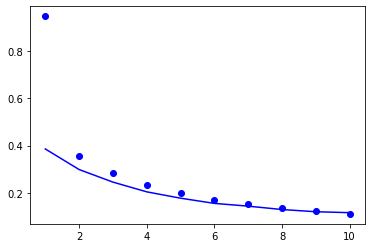

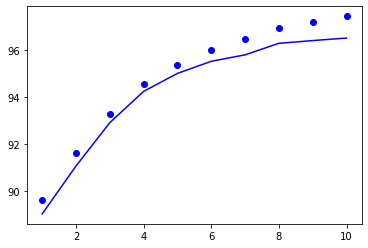

In [17]:
# plot the loss and accuracy for each epochs
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'b', label='Validation loss')

plt.figure()

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, valid_acc, 'b', label='Validation accuracy')
plt.show()

In [18]:
# load model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Evaluate the performance of the trained model on a test dataset

In [19]:
# track test loss
test_loss = 0.0
# prepare to count predictions for each class
correct_pred = list(0. for i in range(10))
total_pred = list(0. for i in range(10))

# again no gradients needed
with torch.no_grad():
    for images, labels in test_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        # calculate the batch loss
        loss = criterion(outputs, labels)
        # update test loss 
        test_loss += loss.item()*images.size(0)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label] += 1
            total_pred[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}'.format(test_loss))

# average accuracy
print('Test Accuracy: %2d%% (%2d/%2d)\n' % (
    100. * np.sum(correct_pred) / np.sum(total_pred),
    np.sum(correct_pred), np.sum(total_pred)))

for i in range(10):
    if total_pred[i] > 0:
        print('Test Accuracy of %2s: %2d%% (%2d/%2d)' % (
            str(i), 100 * correct_pred[i] / total_pred[i],
            np.sum(correct_pred[i]), np.sum(total_pred[i])))
    else:
        print('Test Accuracy of %2s: N/A (no training examples)' % (classes[i]))

Test Loss: 0.104186
Test Accuracy: 96% (9689/10000)

Test Accuracy of  0: 98% (965/980)
Test Accuracy of  1: 99% (1127/1135)
Test Accuracy of  2: 96% (998/1032)
Test Accuracy of  3: 96% (977/1010)
Test Accuracy of  4: 97% (959/982)
Test Accuracy of  5: 97% (866/892)
Test Accuracy of  6: 96% (927/958)
Test Accuracy of  7: 96% (996/1028)
Test Accuracy of  8: 95% (928/974)
Test Accuracy of  9: 93% (946/1009)


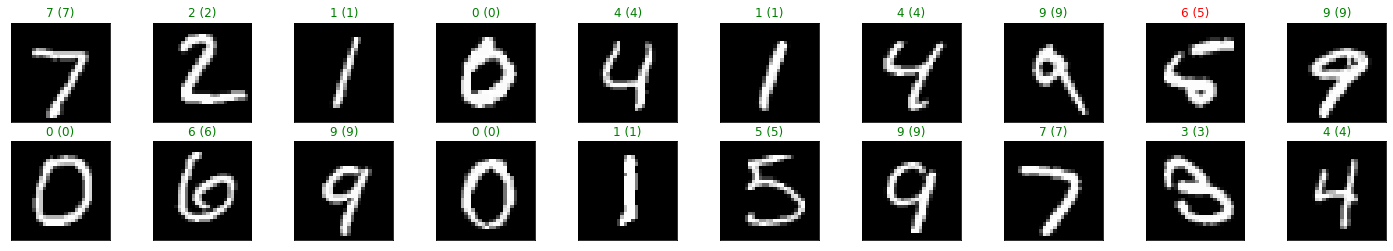

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

# prep images for display
inputs.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    inputs = inputs.cuda()

# get sample outputs
outputs = model(inputs)
# convert output probabilities to predicted class
_, predictions = torch.max(outputs, 1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    if not train_on_gpu:
      ax.imshow(np.squeeze(inputs[idx]))
    else:
       ax.imshow(np.squeeze(inputs[idx]).cpu(), cmap='gray')
    ax.set_title("{} ({})".format(str(predictions[idx].item()), str(labels[idx].item())),
                 color=("green" if predictions[idx]==labels[idx] else "red"))